In [43]:
%%configure
{ "conf": {"spark.jars.packages": "com.databricks:spark-avro_2.11:4.0.0" }}

A session has already been started. If you intend to recreate the session with new configurations, please include the -f argument.


In [44]:
import sys
import json
import pickle

from functools import reduce
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import udf, mean, lit, stddev, col, expr, when, size
from pyspark.sql.types import DoubleType, ArrayType, ShortType, LongType, IntegerType
import pandas as pd
from collections import OrderedDict
from datetime import date
import numpy as np
from scipy import signal

from pyspark.ml import Pipeline, PipelineModel

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier

from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer
from pyspark.ml import PipelineModel

In [45]:
spark = SparkSession\
    .builder\
    .appName("AvroKeyInputFormat")\
    .getOrCreate()

In [46]:
STORAGE_ACCOUNT_SUFFIX = 'core.windows.net'
STORAGE_ACCOUNT_NAME = 'stg5rxrlilnewrny'
TELEMETRY_CONTAINER_NAME = 'telemetry'

wasbUrlInput = "wasb://{0}@{1}.blob.{2}/*/*/*/*/*/*/*".format(
            TELEMETRY_CONTAINER_NAME,
            STORAGE_ACCOUNT_NAME,
            STORAGE_ACCOUNT_SUFFIX)

sc = spark.sparkContext

hc = sc._jsc.hadoopConfiguration()
hc.set("avro.mapred.ignore.inputs.without.extension", "false")
# hc.set("fs.azure.account.key.{}.blob.core.windows.net".format(STORAGE_ACCOUNT_NAME), STORAGE_ACCOUNT_KEY)

sql = SQLContext(sc)

df = sql.read.format("com.databricks.spark.avro").load(wasbUrlInput)

In [47]:
df.printSchema()

root
 |-- EnqueuedTimeUtc: string (nullable = true)
 |-- Properties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- SystemProperties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- Body: binary (nullable = true)

In [48]:
sample_rate = 8000

def extract_double(c):
    return udf(lambda x: float(pickle.loads(x)[c]), DoubleType())

def extract_array(c):
    return udf(lambda x: pickle.loads(x)[c], ArrayType(ShortType()))

def extract_amplitude_spectrum(c):
    def m(x):
        ampl = np.abs(np.fft.fft(pickle.loads(x)[c])) / sample_rate
        return ampl[:sample_rate // 2 + 1].tolist()
                      
    return udf(m, ArrayType(DoubleType()))

def extract_dominant_frequencies(index):
    def m(ff):
        freq = np.fft.fftfreq(sample_rate, d = 1/sample_rate)[:sample_rate // 2 + 1]
        return [float(f[index]) for f in sorted(list(zip(freq, ff)), key = lambda x: x[1], reverse = True)]
    
    return udf(m, ArrayType(DoubleType()))


dfa = (df
       .withColumn('machineID', df.SystemProperties['connectionDeviceId'])
       .withColumn("speed", extract_double("speed")(df.Body))
       .withColumn("temperature", extract_double("temperature")(df.Body))
       .withColumn("pressure", extract_double("pressure")(df.Body))
       .withColumn("vibration", extract_array("vibration")(df.Body))
       .withColumn("fft", extract_amplitude_spectrum("vibration")(df.Body))
       .drop('Properties', 'SystemProperties', 'Body'))

dfa = (dfa
       .withColumn("dominant_frequencies", extract_dominant_frequencies(0)(dfa.fft))
       .withColumn("dominant_frequencies_amplitudes", extract_dominant_frequencies(1)(dfa.fft)))

In [49]:
dfa.printSchema()
samples = dfa.limit(5).toPandas()
dfa.registerTempTable('dfa')

root
 |-- EnqueuedTimeUtc: string (nullable = true)
 |-- machineID: string (nullable = true)
 |-- speed: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- vibration: array (nullable = true)
 |    |-- element: short (containsNull = true)
 |-- fft: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dominant_frequencies: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dominant_frequencies_amplitudes: array (nullable = true)
 |    |-- element: double (containsNull = true)

In [74]:
%%sql -q -o fft_sample
SELECT vibration, fft FROM dfa WHERE machineID='pm1-353' ORDER BY EnqueuedTimeUtc LIMIT 100

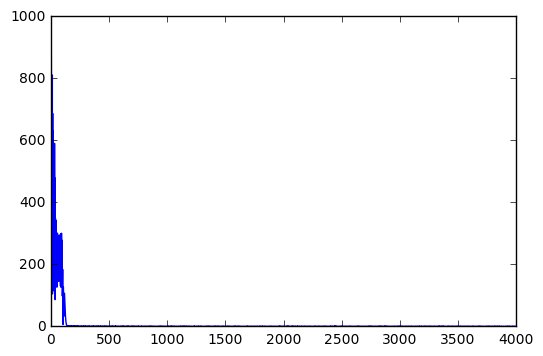

In [92]:
%%local
import matplotlib.pyplot as plt

# can this be done easier?
sample = fft_sample.loc(0)[0]['fft']
# print(sample)
plt.plot(sample)
plt.show()

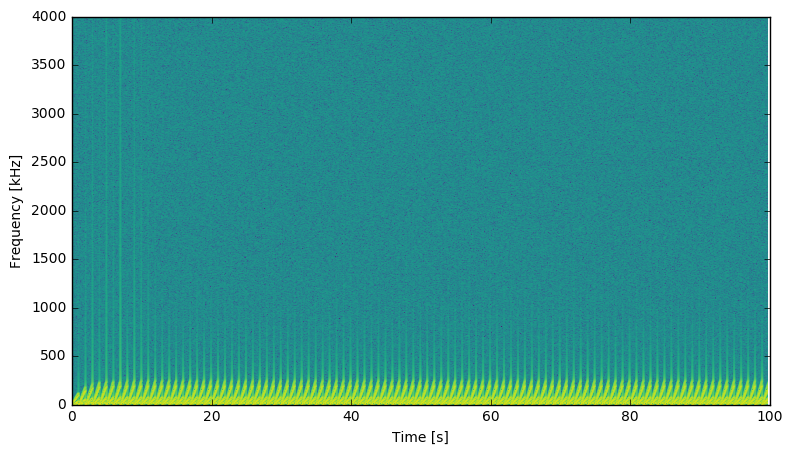

In [88]:
%%local

import numpy as np
from scipy import signal

k = np.concatenate(np.array([x['vibration'] for _, x in fft_sample.iterrows()]))
freqs, times, Sx = signal.spectrogram(k, fs=8000, window='hanning',
                                      nperseg=4096, noverlap=4096 - 100,
                                      detrend=False, scaling='spectrum')
f, ax = plt.subplots(figsize=(9, 5))
ax.pcolormesh(times, freqs, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]')
plt.show()

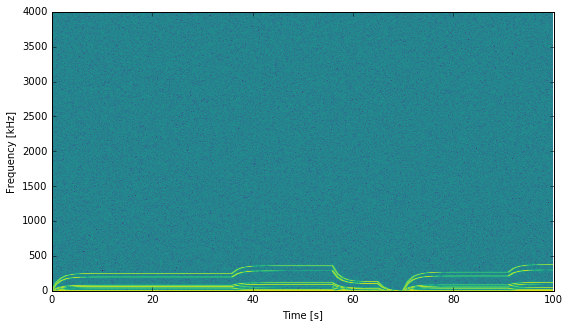

In [20]:
freq = np.fft.fftfreq(sample_rate, d = 1/sample_rate)[:sample_rate // 2 + 1]
max_freq = sorted(list(zip(freq, dfa.sample(False, 0.1, seed=0).first().fft)), key = lambda x: x[1], reverse = True)[10 : ]
pdf = pd.DataFrame.from_records(max_freq)
pdf.head()

      0           1
0  10.0  459.653659
1  42.0  449.293098
2  22.0  449.210820
3  49.0  442.764850
4  38.0  440.357586

In [21]:
frequency_features = 3
dfa = reduce(lambda _df, i: _df.withColumn('f{0}'.format(i), _df.dominant_frequencies[i]), range(frequency_features), dfa)
dfa = reduce(lambda _df, i: _df.withColumn('a{0}'.format(i), _df.dominant_frequencies_amplitudes[i]), range(frequency_features), dfa)
dfa = dfa.drop('vibration', 'fft', 'dominant_frequencies', 'dominant_frequencies_amplitudes')

In [22]:
dependent_features = [c for c in dfa.columns if c not in ['machineID', 'EnqueuedTimeUtc', 'speed']]
dfa = reduce(lambda _df, f: _df.withColumn('{0}_n'.format(f), col(f) / col('speed')), dependent_features, dfa)

In [23]:
dfa.limit(5).toPandas().head()

                EnqueuedTimeUtc machineID   speed  temperature    pressure  \
0  2018-03-06T21:50:07.7820000Z   pm1-354  1220.0    20.103015  861.021138   
1  2018-03-06T21:50:07.8450000Z   pm1-355  1330.0    20.120121  832.816415   
2  2018-03-06T21:50:08.7670000Z   pm1-355  1330.0    20.120121  832.816415   
3  2018-03-06T21:50:08.7820000Z   pm1-354  1220.0    20.103015  861.021138   
4  2018-03-06T21:50:09.7980000Z   pm1-354  1220.0    20.103015  861.021138   

    f0   f1   f2          a0          a1          a2  temperature_n  \
0  1.0  2.0  0.0  621.564237  620.339708  618.844750       0.016478   
1  2.0  1.0  0.0  587.969836  586.377787  582.418000       0.015128   
2  2.0  1.0  0.0  587.855871  586.599828  582.882125       0.015128   
3  1.0  2.0  0.0  622.132863  621.159591  619.436625       0.016478   
4  1.0  2.0  0.0  621.925837  621.297052  618.408125       0.016478   

   pressure_n      f0_n      f1_n  f2_n      a0_n      a1_n      a2_n  
0    0.705755  0.000820  0.00163

In [24]:
features = [c for c in dfa.columns if c not in ['machineID', 'EnqueuedTimeUtc']]

# assemble features
va = VectorAssembler(inputCols=(features), outputCol='features')

# this is a hack!! In the current simulated dataset, there are 4 machines: machine 0 is "good," 
# whereas the rest are experiencing different failures. This will eventually be produced by merging 
# telemetry with the "maintenance log"
feat_data = va.transform(dfa).select('machineID', 'features').withColumn('label_e', dfa.machineID.substr(-1, 1).cast(IntegerType()))

feat_data.cache()

feat_data.limit(10).toPandas().head()

  machineID                                           features  label_e
0   pm1-354  [1220.0, 20.1030149504, 861.021138263, 1.0, 2....        4
1   pm1-355  [1330.0, 20.1201206477, 832.816415336, 2.0, 1....        5
2   pm1-355  [1330.0, 20.1201206477, 832.816415336, 2.0, 1....        5
3   pm1-354  [1220.0, 20.1030149504, 861.021138263, 1.0, 2....        4
4   pm1-354  [1220.0, 20.1030149504, 861.021138263, 1.0, 2....        4

In [25]:
# set maxCategories so features with > 10 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", 
                               outputCol="indexedFeatures", 
                               maxCategories=10).fit(feat_data)

# fit on whole dataset to include all labels in index
labelIndexer = StringIndexer(inputCol="label_e", outputCol="indexedLabel").fit(feat_data)

In [26]:
training, test = feat_data.randomSplit([0.8, 0.2], seed=12345)
print(training.count())
print(test.count())
feat_data.limit(5).toPandas().head()

6818
1748
  machineID                                           features  label_e
0   pm1-354  [1220.0, 20.1030149504, 861.021138263, 1.0, 2....        4
1   pm1-355  [1330.0, 20.1201206477, 832.816415336, 2.0, 1....        5
2   pm1-355  [1330.0, 20.1201206477, 832.816415336, 2.0, 1....        5
3   pm1-354  [1220.0, 20.1030149504, 861.021138263, 1.0, 2....        4
4   pm1-354  [1220.0, 20.1030149504, 861.021138263, 1.0, 2....        4

In [27]:
model_type = 'DecisionTree' # Use 'DecisionTree', or 'RandomForest'

# train a model.
if model_type == 'DecisionTree':
    model = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures",
                                      # Maximum depth of the tree. (>= 0) 
                                      # E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'
                                      maxDepth=15,
                                      # Max number of bins for discretizing continuous features. 
                                      # Must be >=2 and >= number of categories for any categorical feature.
                                      maxBins=32, 
                                      # Minimum number of instances each child must have after split. 
                                      # If a split causes the left or right child to have fewer than 
                                      # minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.
                                      minInstancesPerNode=1, 
                                      # Minimum information gain for a split to be considered at a tree node.
                                      minInfoGain=0.0, 
                                      # Criterion used for information gain calculation (case-insensitive). 
                                      # Supported options: entropy, gini')
                                      impurity="gini")

    ##=======================================================================================================================
    #elif model_type == 'GBTClassifier':
    #    cls_mthd = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")
    ##=======================================================================================================================
else:    
    model = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", 
                                      # Passed to DecisionTreeClassifier
                                      maxDepth=15, 
                                      maxBins=32, 
                                      minInstancesPerNode=1, 
                                      minInfoGain=0.0,
                                      impurity="gini",
                                      # Number of trees to train (>= 1)
                                      numTrees=50, 
                                      # The number of features to consider for splits at each tree node. 
                                      # Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].
                                      featureSubsetStrategy="sqrt", 
                                      # Fraction of the training data used for learning each 
                                      # decision tree, in range (0, 1].' 
                                      subsamplingRate = 0.632)

# chain indexers and model in a Pipeline
pipeline_cls_mthd = Pipeline(stages=[labelIndexer, featureIndexer, model])

# train model.  This also runs the indexers.
model_pipeline = pipeline_cls_mthd.fit(training)

In [28]:
# make predictions. The Pipeline does all the same operations on the test data
predictions = model_pipeline.transform(test)

# Create the confusion matrix for the multiclass prediction results
# This result assumes a decision boundary of p = 0.5
conf_table = predictions.stat.crosstab('indexedLabel', 'prediction')
confuse = conf_table.toPandas().sort_values(by=['indexedLabel_prediction'])
confuse.head()

  indexedLabel_prediction  0.0  1.0  2.0  3.0
3                     0.0  472    1    0    0
1                     1.0    0  425    0    0
0                     2.0    0    0  443    0
2                     3.0    0    0    0  407